# Peut-on détecter automatiquement les villes dont l'aire urbaine explose ?

## Données
+ Images google 



In [1]:
# Utilities to learn the model


import numpy as np
import matplotlib.pyplot as plt
import os

from skimage import color
from skimage import transform
from skimage import io
from skimage import measure
from skimage import morphology
from skimage import filters

from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.feature_extraction import image
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import MiniBatchDictionaryLearning

lmask = "new_masks/"
limage = "new_img/"
patch_size = (10,10)
thresh_label = 0.5
ratio = 0.10
th = 0.5

pixel_area = (5.5*5.5)/(60*60)


def convert_mask(msk, shape):
#msk must be a numpy matrix
# arrange the mask so its shape is equal to the shape of an image 
    return np.bool_(transform.resize (color.rgb2grey(msk), [shape[0], shape[1]]))

def extract_linepatch(img, patch_size):
    temp = extract_patches_2d(img,patch_size)
    temp = temp/255

    temp = temp.reshape(temp.shape[0], -1)
    temp -= np.mean(temp, axis=0)
    temp /= np.std(temp, axis=0)
    return temp


def extract_label_from_mask(msk, patch_size):
    
    temp = extract_patches_2d(msk,patch_size)
    temp = temp/255
    temp = temp.reshape(temp.shape[0], -1)
    label = np.zeros((temp.shape[0],))
    for i in range(label.shape[0]):
        label[i] = np.mean(temp[i,:])
        
    return label

def bina(label, th):
    label[label > th] = 1
    label[label <= th] = 0
    return label
                
    
def label2mask(label, shape, patch_size):
    msk = np.zeros((len(label),patch_size[0]*patch_size[1]*3))
    for i in range (msk.shape[0]):
        msk[i,:] = np.ones(msk.shape[1]) * label_predict[i]
    
    msk = msk.reshape(msk.shape[0], *patch_size,3)
    
    return reconstruct_from_patches_2d( msk*255, shape)

#Utilities to evaluate

def pix2km(area, pixel_area):
    t =[]
    for i in range(len(area)):
        t.append(area[i]*pixel_area)
    return t

def compute_evolution(area):
    evolution = []
    evolution_an = []
    for i in range(len(area)-1):
        ev = (area[i+1] - area[i] )/ area[i+1]
        evolution.append(ev*100)
        evolution_an.append(ev*100/(year[i+1]-year[i]))
    return evolution, evolution_an

def year2int(year):
    inte = []
    for i in range(len(year)-1):
        inte.append(str(year[i])+"-"+str(year[i+1]))
    return inte



## Phase 1: Apprendre ce qu'est une tâche urbaine

+ 5 villes du Cameroun à 4 pas de temps différents
+ Pas de filtres
+ Un algorithme basique de Machine Learning

Comment ça marche ?
+ L'algorithme regarde 10% des 20 images, de façon aléatoire
+ On lui a indiqué où était la tâche urbaine sur ces images, de façon approximative
+ L'algorithme "apprend" donc par lui-même ce qu'est une tâche urbaine (ici approche sur le contraste local
+ Grande importance à avoir de la variabilité dans l'information de départ

In [2]:
# Loading data...

villes = ['00_douala_00.jpg', '00_yaoundé_00.jpg', '01_bafoussam_01.jpg', '01_ngaoundéré_01.jpg', '01_nkongsamba_01.jpg', '05_bafoussam_05.jpg', '05_douala_05.jpg', '06_ngaoundéré_06.jpg', '06_nkongsamba_06.jpg', '06_yaoundé_06.jpg', '10_bafoussam_10.jpg', '11_douala_11.jpg', '11_ngaoundéré_11.jpg', '11_nkongsamba_11.jpg', '11_yaoundé_11.jpg', '15_bafoussam_15.jpg', '15_douala_15.jpg', '15_ngaoundéré_15.jpg', '15_nkongsamba_15.jpg', '15_yaoundé_15.jpg']
baffoussam = ['00_bamenba_00.jpg' , '05_bamenba_05.jpg', '10_bamenba_10.jpg','15_bamenba_15.jpg']

#List of satellite images
liste_img = villes
#Liste of masks
liste_msk = villes

train= np.random.permutation(len(liste_img))

data = extract_linepatch(io.imread(limage+liste_img[train[0]]), patch_size)
label = bina(extract_label_from_mask(io.imread(lmask+liste_msk[train[0]]),patch_size),th)

#We define the number of patches we will extract per images
blk = int(data.shape[0]*ratio)

#We initialize big_data and big_label
big_data = np.zeros((len(liste_img)*blk,patch_size[0]*patch_size[1]*3))
big_label = np.zeros((len(liste_img)*blk,))

v =np.random.permutation(data.shape[0])[0:blk]
big_data[:blk,:] = data[v]
big_label[:blk] = label[v]

for i in range(len(train)-1):
    data = extract_linepatch(io.imread(limage+liste_img[train[i+1]]), patch_size)
    label = bina(extract_label_from_mask(io.imread(lmask+liste_msk[train[i+1]]),patch_size),th)
    v =np.random.permutation(data.shape[0])[0:blk]
    big_data[blk*(i+1):(blk*(i+2)),:] = data[v]
    big_label[blk*(i+1):(blk*(i+2))] = label[v]



from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=64)
clf = clf.fit(big_data, big_label)





## Phase 2: Utiliser l'algorithme :)

Maintenant l'algorithme a inféré sur ce qu'était une tâche urbaine et ce qui était autre chose. Sur des images nouvelles, il peut donc labeliser la zone où se trouve la ville.
Nous avons pris l'exemple de Bamemba au hasard

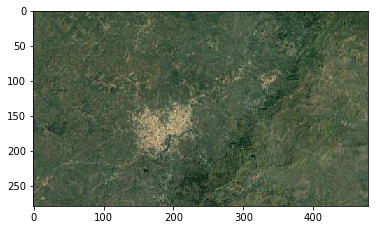

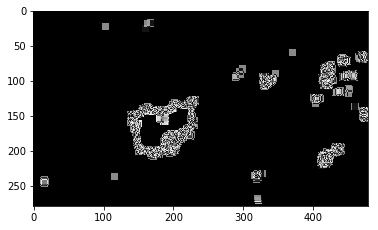

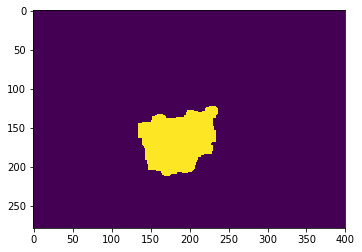

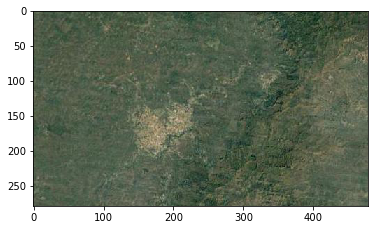

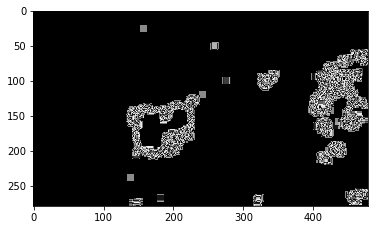

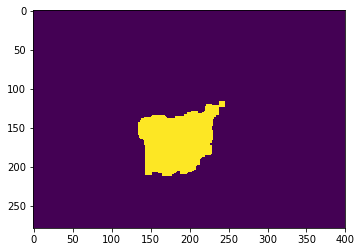

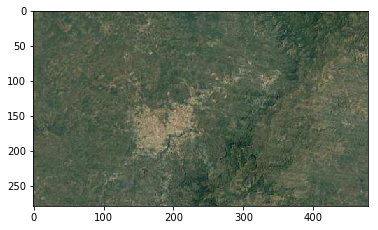

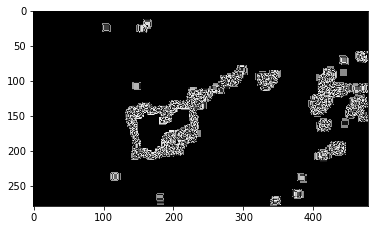

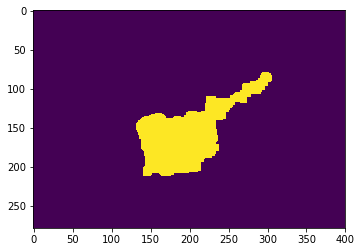

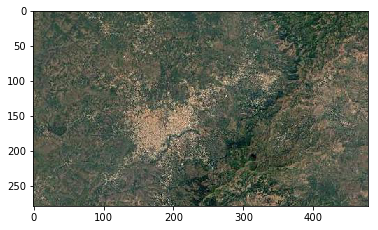

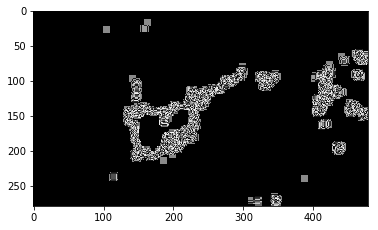

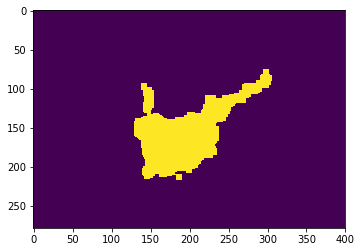

In [3]:
from scipy import ndimage as ndi

kernel = np.ones((3,3), np.uint8)

prediction = []

for i in baffoussam:
    
    t =io.imread(limage+i)
    
    plt.imshow(t)
    plt.show()
    
    
    tt = extract_linepatch(t, patch_size)
    label_predict = clf.predict(tt)
    msk_predict = label2mask(label_predict, t.shape, patch_size)
    
    
    plt.imshow(msk_predict)
    plt.show()
    
    pred = bina(msk_predict,0.5)
    pred = pred[:,:400]

    pred = ndi.binary_fill_holes(color.rgb2grey(pred))
    
    pred = morphology.binary_erosion(pred, kernel)
    
    label_objects, nb_labels = ndi.label(pred)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > 1000
    mask_sizes[0] = 0
    pred = mask_sizes[label_objects]


    
    plt.imshow(pred)
    plt.show()
    prediction.append(pred)


    #io.imsave('pred_'+liste_img[i], np.uint8(msk_predict)*255)

## Phase 3:Data Driven ou passer de la donnée à l'information

Une fois la donnée créée par les algorithmes, il est nécessaire de la traiter afin de créer des informations utiles, exploitables par l'utilisateur

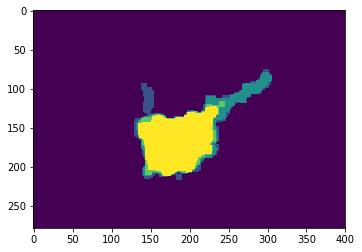

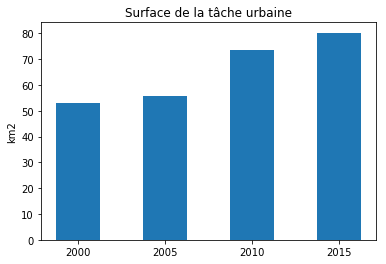

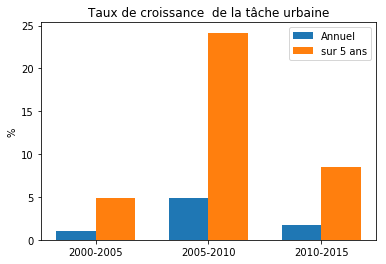

In [19]:
year = []
area=[]
#Get evolution in one image
image = np.zeros(prediction[0].shape)
for i in range(len(prediction)):
    image += prediction[i]
    year.append(int('20'+baffoussam[i][0:2]))
    area.append(np.sum(prediction[i]))
    
image /= len(prediction)

plt.imshow(image)


[ev, eva]= compute_evolution(area)
y =[]
for i in year:
    y.append(str(i))



width = 0.5
ind = np.arange(len(year))
fig, ax = plt.subplots()
rects1 = ax.bar(ind, pix2km(area, pixel_area), width)
ax.set_title('Surface de la tâche urbaine')
ax.set_xticks(ind)
ax.set_ylabel('km2')
ax.set_xticklabels(y)

width = 0.35
ind = np.arange(3)
fig, ax = plt.subplots()
rects1 = ax.bar(ind, eva, width)
rects2 = ax.bar(ind+width, ev, width)
ax.set_title('Taux de croissance  de la tâche urbaine')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(year2int(year))
ax.set_ylabel('%')
ax.legend((rects1[0], rects2[0]),('Annuel', 'sur 5 ans'))

## A quoi ressemblerait une phase 4 ?
+ Phase 0: Automatisation de la phase d'acquisition des images pour <it>screener</it> l'ensemble des villes moyennes
+ Phase 1: Améliorer l'algorithme d'apprentissage pour le rendre plus précis et surtout un algorithme capable de continuer à apprendre
+ Phase 2: Avoir une possibilité de valider la prédiction (permet d'améliorer l'algorithme)
+ Phase 3: Intégration à un dashboard, imaginer de nouvelles métriques, système d'alerte pour la stratégie.